In [1]:
import warnings
import sys
sys.path.append('../')
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from tabulate import tabulate
from texttable import Texttable

import latextable
from PrepareData import read_json, make_folder

In [3]:
seeds = [1, 12345, 6, 2211, 15]

In [4]:
def flip_label(x):
    if x.iloc[0] == 0:
        return int(1-x.iloc[1])
    else:
        return x.iloc[1]
def flip_label_ma(x):
    if x.iloc[0] == 1:
        return int(1-x.iloc[1])
    else:
        return x.iloc[1]

In [5]:
def draw_scatter_plot(df, output_name_with_path):
    fig, ax = plt.subplots(1, figsize=(8, 6), dpi=220)
    groups = [1, 1, 0, 0]
    labels = [0, 1, 0, 1]
    markers = ['^', 'o', '^', 'o']
    # colors = ['blue', 'blue', 'orange', 'orange']
    colors = ['#0C2340', '#0C2340', '#F15A22', '#F15A22']
    legends = ['majority + negative', 'majority + positive', 'minority + negative', 'minority + positive']

    for group_i, label_i, marker_i, color_i in zip(groups, labels, markers, colors):
        cur_df = df.query('A=={} and Y=={}'.format(group_i, label_i))

        plt.scatter(cur_df['X1'], cur_df['X2'], c=color_i, marker=marker_i, edgecolors=color_i, s=5, label='')
    plt.savefig(output_name_with_path, bbox_inches="tight") 
    print('Scatter plot is saved at ', output_name_with_path)
    plt.close()

In [6]:
# generate synthetic data
repo_dir = sys.path[0].replace('notebooks', '')
data_path= repo_dir+ 'data/processed/'
plot_path = repo_dir + 'intermediate/plots/syn/'
# x1_centers = [1.2, 1.5, 1.3, 1.6] 

# for simulating lower DI 
x1_centers = [1.2, 1.5, 1.1, 1.4]

x1_std = [0.1, 0.1, 0.1, 0.1]

default_sigma = 0.02

x2_centers = [1, 1.2, 0.8, 0.8]
# x2_std = [0.1, 0.1, 0.1, 0.1]

weights_x1 = [-0.6, -0.6, 0.6, 0.6]
weights_x2 = [-0.2, -0.2, -0.4, -0.4]

conds = [-1, -1, 0.6, 0.6]
sizes = [5500, 2500, 500, 1500]

groups = [1, 1, 0, 0]
labels = [0, 1, 0, 1]

# rate_error = 0.2

for idx, seed in enumerate(seeds):
    np.random.seed(seed)
    cur_sigma_x2 = default_sigma / (idx+1)
    
    sample_df = pd.DataFrame(columns=['A', 'X1', 'X2', 'Y_prob', 'Y'])
    
    for mu_x1, sigma_x1, mu_x2, weight_x1, weight_x2, cond_i, group_i, size_i in zip(x1_centers, x1_std, x2_centers, weights_x1, weights_x2, conds, groups, sizes):
        cur_x1_values = np.random.normal(mu_x1, sigma_x1, size_i)
        cur_x2_values = np.random.normal(mu_x2, cur_sigma_x2, size_i)
        
        for x1_i, x2_i in zip(cur_x1_values, cur_x2_values):
            y_i = weight_x1*x1_i + weight_x2* x2_i

            if cond_i > 0:
                y_int_i = int(y_i < cond_i)
            else:
                y_int_i = int(y_i > cond_i)
            sample_df.loc[sample_df.shape[0]] = [group_i, x1_i, x2_i, y_i, y_int_i]
    
    # flipping the positive and negative for minority group A=0
    sample_df['Y'] = sample_df[['A', 'Y']].apply(lambda x: flip_label(x), axis=1)
    # flipping the positive and negative for majority group A=1 so that the unfairness against A=0 at the begining, DI<0.8
    
    sample_df['Y'] = sample_df[['A', 'Y']].apply(lambda x: flip_label_ma(x), axis=1)
    
#     # simulate mislabeled group membership in A=1 group with postive label
#     center_df = sample_df.query('{}<X1<{} and {}<X2<{} and A==1'.format(x1_centers[0]-sigma_x1, x1_centers[0]+sigma_x1, x2_centers[0]-cur_sigma_x2, x2_centers[0]+cur_sigma_x2))
#     error_indexes = center_df.head(int(center_df.shape[0]*rate_error)).index
#     sample_df.loc[error_indexes,'A'] = 0
    
    sample_df = sample_df.drop(columns=['Y_prob'])
    sample_df.to_csv('{}syn{}.csv'.format(data_path, seed), index=False)
    plot_name = plot_path + 'sigma{:.3f}_DI.png'.format(cur_sigma_x2)
    
#     plot_name = plot_path + 'sigma{:.3f}_error{}.png'.format(cur_sigma_x2, rate_error)
    print('syn', idx+1, 'sigma{:.3f}'.format(cur_sigma_x2))
    draw_scatter_plot(sample_df, plot_name)

syn 1 sigma0.020
Scatter plot is saved at  /Users/keyang/Projects/PubRepo/NonInvasiveTool4FairML/intermediate/plots/syn/sigma0.020_DI.png
syn 2 sigma0.010
Scatter plot is saved at  /Users/keyang/Projects/PubRepo/NonInvasiveTool4FairML/intermediate/plots/syn/sigma0.010_DI.png
syn 3 sigma0.007
Scatter plot is saved at  /Users/keyang/Projects/PubRepo/NonInvasiveTool4FairML/intermediate/plots/syn/sigma0.007_DI.png
syn 4 sigma0.005
Scatter plot is saved at  /Users/keyang/Projects/PubRepo/NonInvasiveTool4FairML/intermediate/plots/syn/sigma0.005_DI.png
syn 5 sigma0.004
Scatter plot is saved at  /Users/keyang/Projects/PubRepo/NonInvasiveTool4FairML/intermediate/plots/syn/sigma0.004_DI.png


In [6]:
sample_df.head()

,A,X1,X2,Y_prob,Y
1,1.0,1.138824,1.049118,-0.893118,1.0
4,1.0,1.286541,1.087793,-0.989483,1.0
9,1.0,1.175063,0.931025,-0.891243,1.0
12,1.0,1.167758,1.064454,-0.913546,1.0
13,1.0,1.161595,0.948940,-0.886745,1.0


In [7]:
len(error_indexes)

509

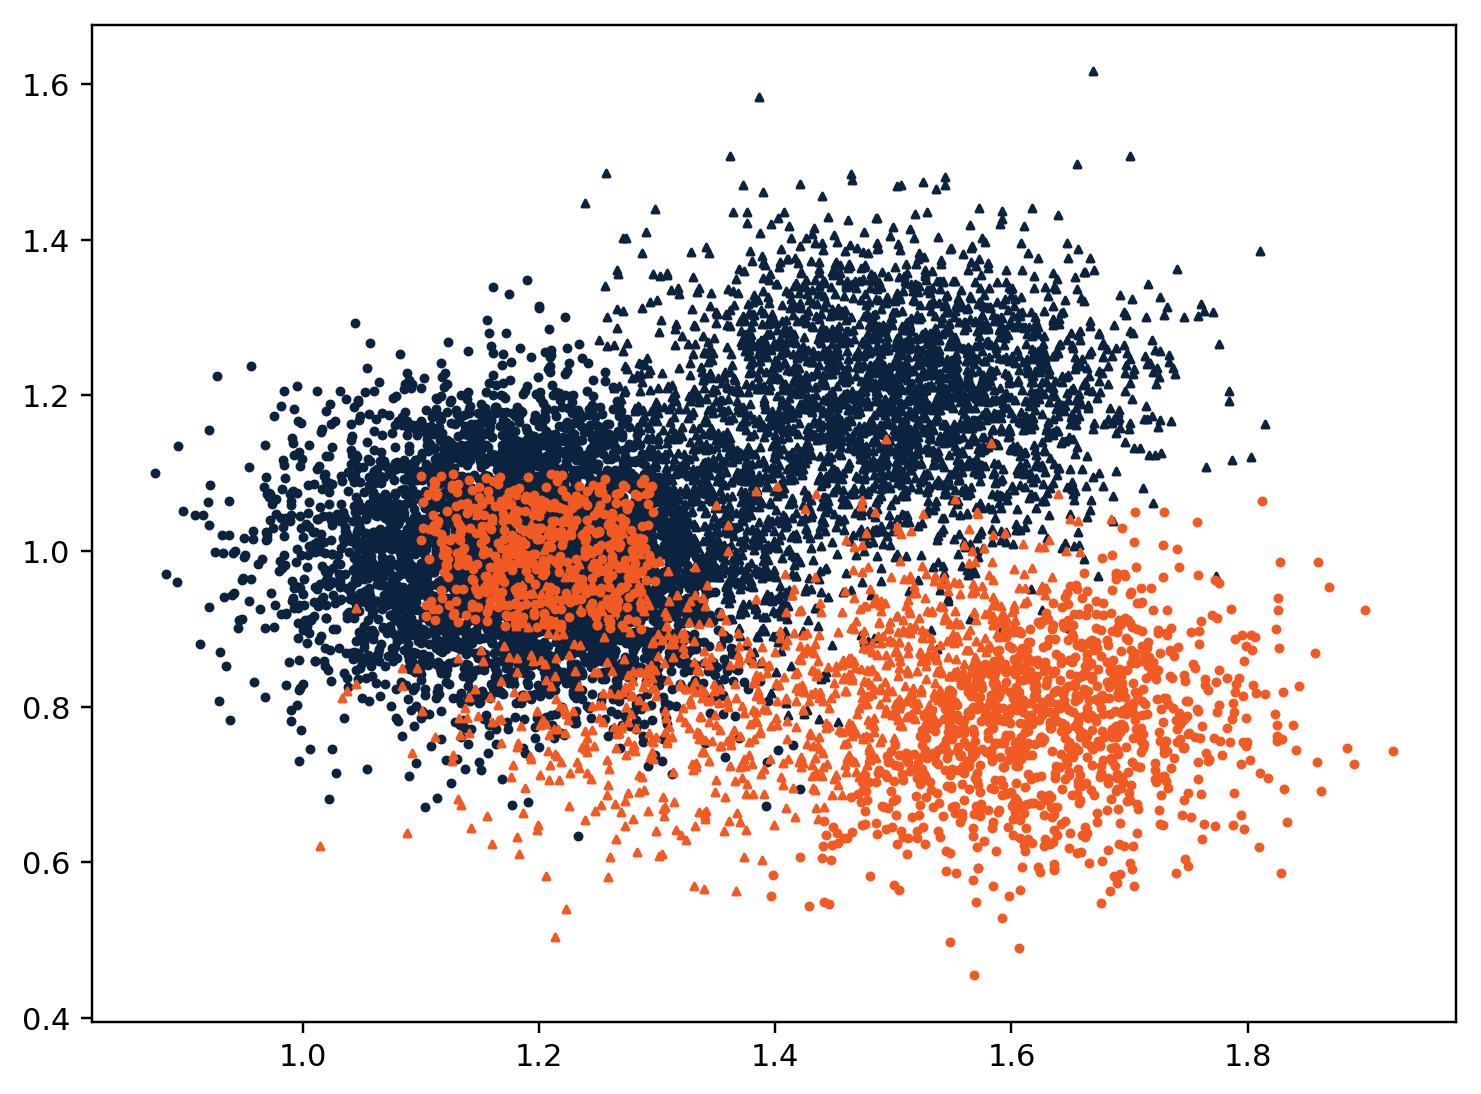

In [8]:
# for test purpose
fig, ax = plt.subplots(1, figsize=(8, 6), dpi=220)
groups = [1, 1, 0, 0]
labels = [0, 1, 0, 1]
markers = ['^', 'o', '^', 'o']
# colors = ['blue', 'blue', 'orange', 'orange']
colors = ['#0C2340', '#0C2340', '#F15A22', '#F15A22']
legends = ['majority + negative', 'majority + positive', 'minority + negative', 'minority + positive']

for group_i, label_i, marker_i, color_i in zip(groups, labels, markers, colors):
    cur_df = sample_df.query('A=={} and Y=={}'.format(group_i, label_i))
    
    plt.scatter(cur_df['X1'], cur_df['X2'], c=color_i, marker=marker_i, edgecolors=color_i, s=5, label='')

    
# for group_i, label_i, marker_i, color_i, legend_i in zip(groups, labels, markers, colors, legends):
#     plt.scatter(-1, -1, c=color_i, marker=marker_i, edgecolors=color_i, s=55, label=legend_i)
    
# line_x1 = [1, 1.2, 1.4, 1.6, 2.0]

# g1_x2 = [-3*x+5 for x in line_x1]
# g0_x2 = [1.5*x-1.5 for x in line_x1]

# plt.plot(line_x1, g1_x2, linestyle='solid', color='black', linewidth=0.8)
# plt.plot(line_x1, g0_x2, linestyle='dashdot', color='orange', linewidth=0.8)
# cc_g1_x1 = [1, 1.2, 1.35]
# cc_g1_x2 = [-3*x+4.95 for x in cc_g1_x1]
# cc_g0_x1 = [1.35, 1.8]
# cc_g0_x2 = [0.9, 0.4]

# plt.plot(cc_g1_x1, cc_g1_x2, linestyle='dashdot', color='green', linewidth=0.8)
# plt.plot(cc_g0_x1, cc_g0_x2, linestyle='dashdot', color='green', linewidth=0.8)

# ax.set_facecolor('#f3f3f3')
# plt.ylim(0.4, 1.5)
# plt.xlim(1.0, 2.0)
# font_s = 30
# plt.xlabel('X1', fontsize=font_s)
# plt.ylabel('X2', fontsize=font_s)
# plt.xticks(fontsize=font_s)
# plt.yticks(fontsize=font_s)
# plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=2, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_s)
# plt.text(1.4, 0.76, '$C_1$', fontsize=font_s)
# plt.text(1.5, 0.83, '$C_2$', fontsize=font_s)
plt.savefig('motivation.png', bbox_inches="tight")

In [29]:
# repo_dir = sys.path[0].replace('notebooks', '')
# data_path=repo_dir+ 'data/processed/'
# # sample_df.drop(columns=['Y_prob'], inplace=True)
# sample_df.to_csv('{}syn{}.csv'.format(data_path, seed), index=False)